In [ ]:
import urllib.request
import io
import gzip
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.multitest import multipletests
from sklearn.decomposition import PCA
import uuid

Error downloading dataset: could not convert string to float: '"GSM120468"'
Using simulated data instead...
After filtering: 939 high-variance genes retained

=== Model Comparison ===

Random Forest Model:
Accuracy: 1.0000
CV Accuracy: 0.9333 ± 0.1333
              precision    recall  f1-score   support

     Control       1.00      1.00      1.00         3
          TB       1.00      1.00      1.00         3

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6


SVM Model:
Accuracy: 0.8333
CV Accuracy: 1.0000 ± 0.0000
              precision    recall  f1-score   support

     Control       0.75      1.00      0.86         3
          TB       1.00      0.67      0.80         3

    accuracy                           0.83         6
   macro avg       0.88      0.83      0.83         6
weighted avg       0.88      0.83      0.83         6


KNN Model:
Accuracy: 0.6667
CV Accu

/Users/Arnav/Documents/PB Project/.ven/lib/python3.13/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/Users/Arnav/Documents/PB Project/.ven/lib/python3.13/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/Users/Arnav/Documents/PB Project/.ven/lib/python3.13/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/Users/Arnav/Documents/PB Project/.ven/lib/python3.13/site-packages/se


Analysis complete. Multiple visualizations created and saved.


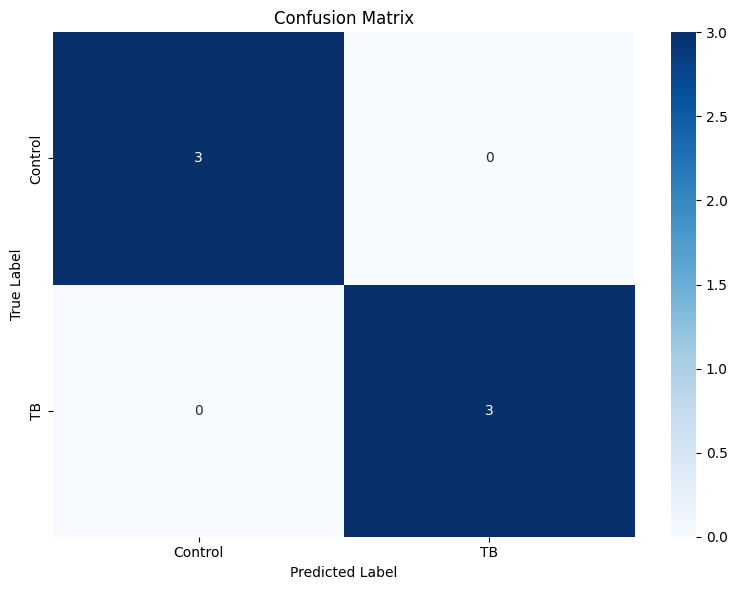

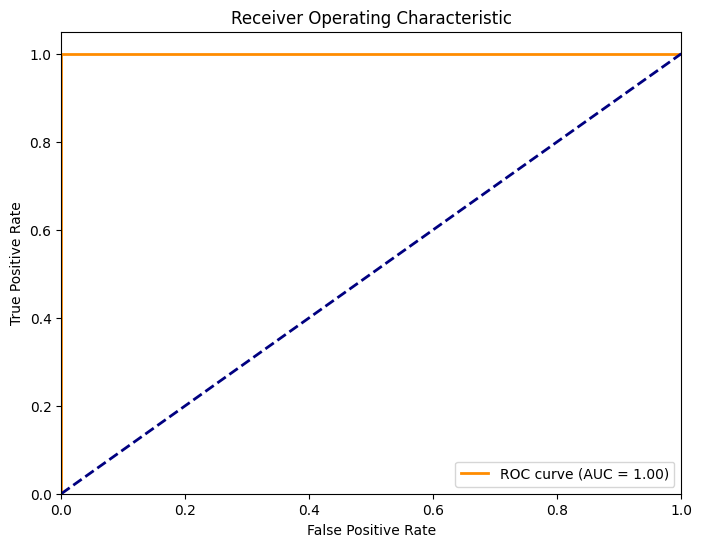

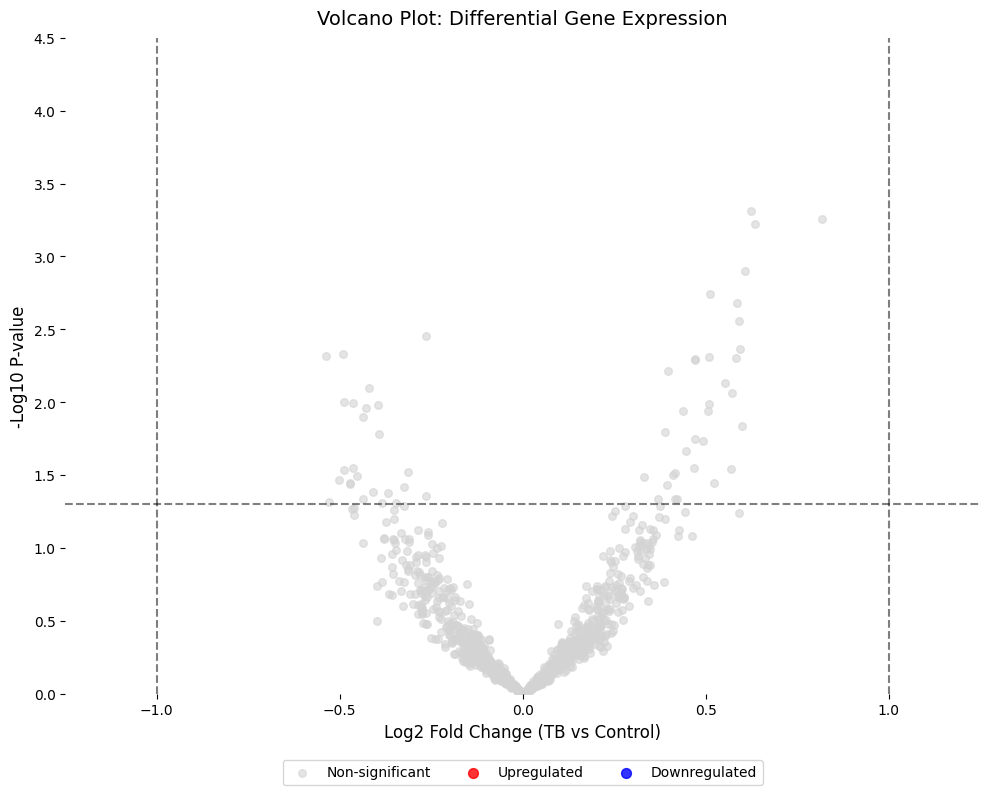

<Figure size 1200x1000 with 0 Axes>

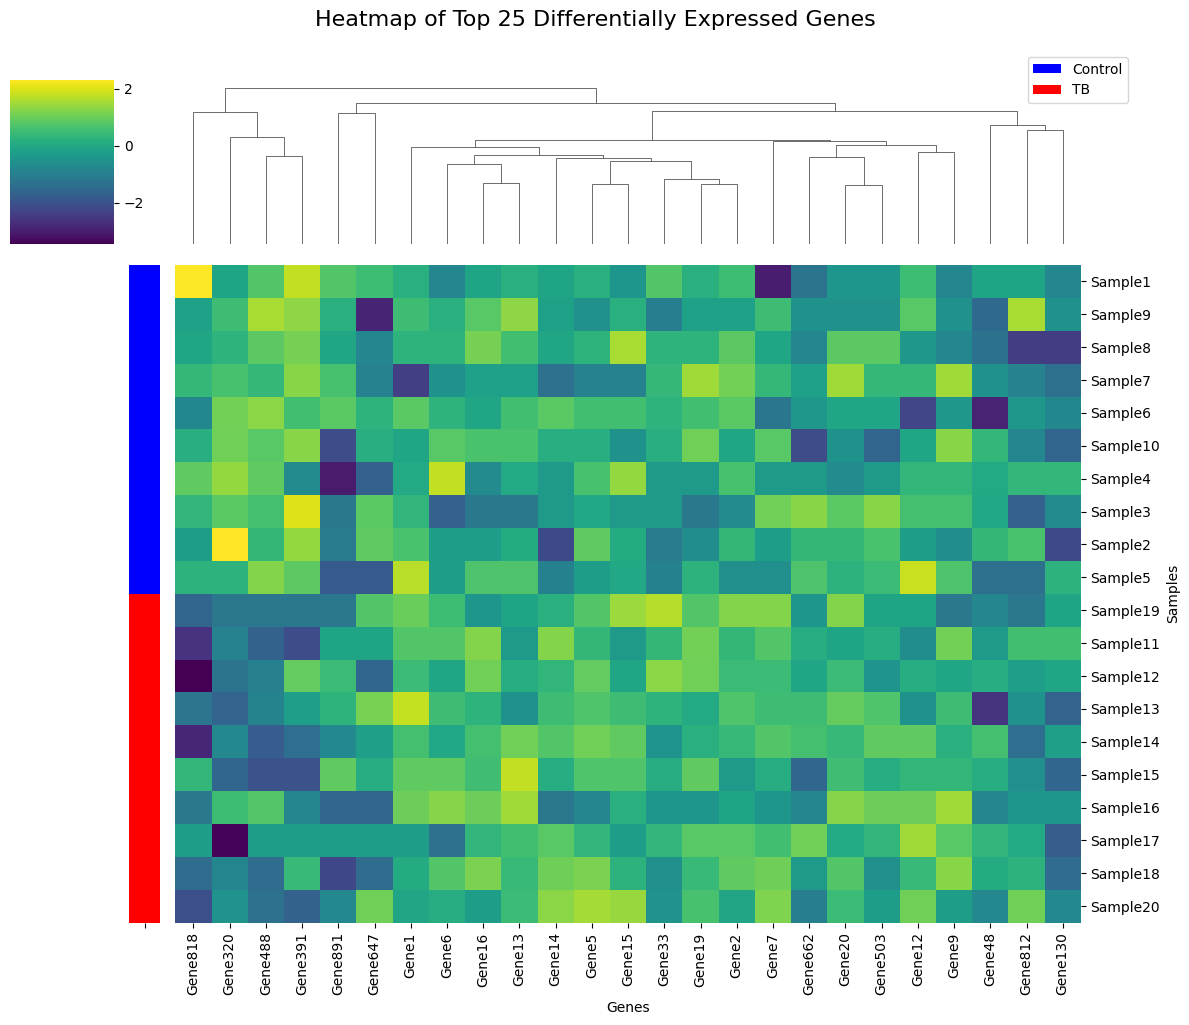

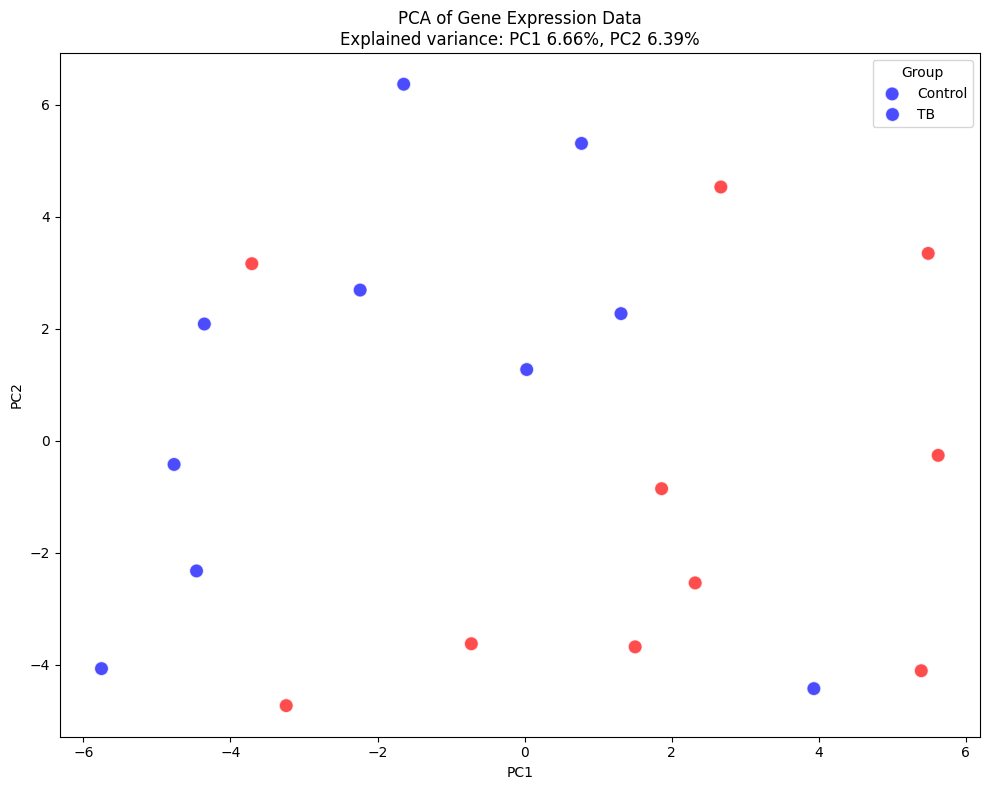

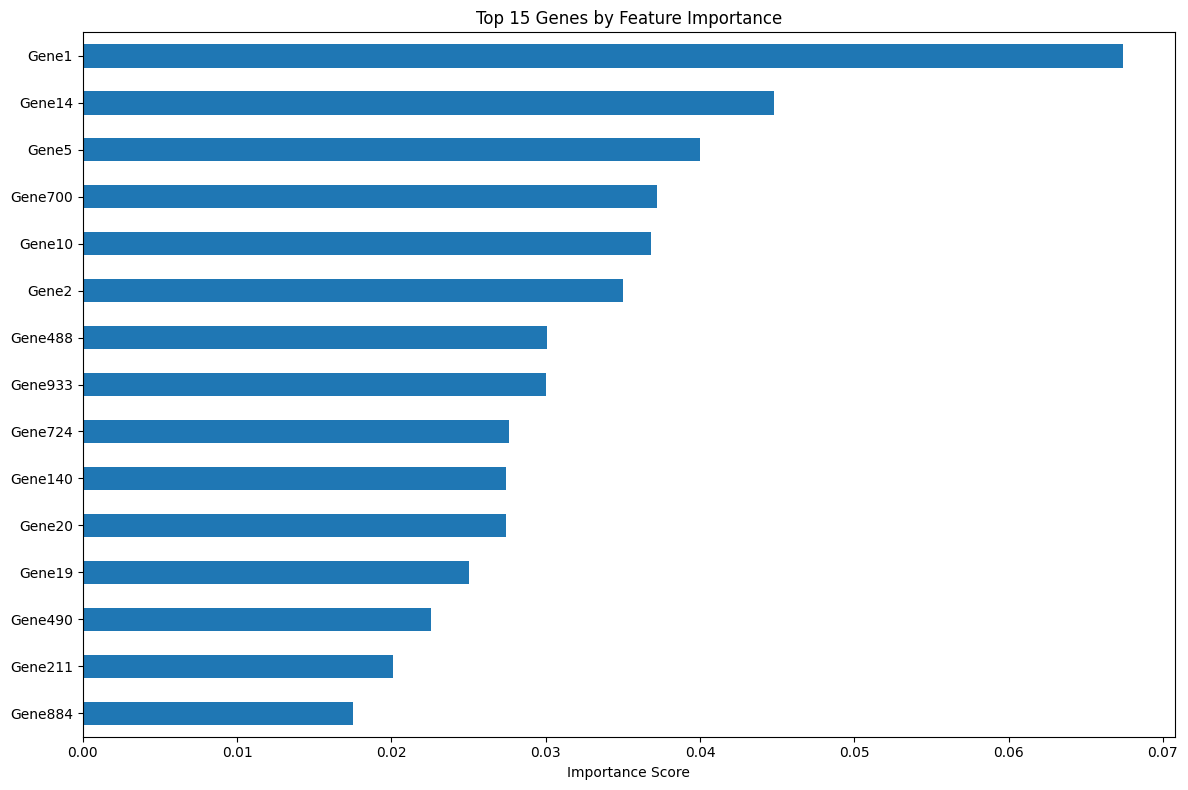

<Figure size 1400x1000 with 0 Axes>

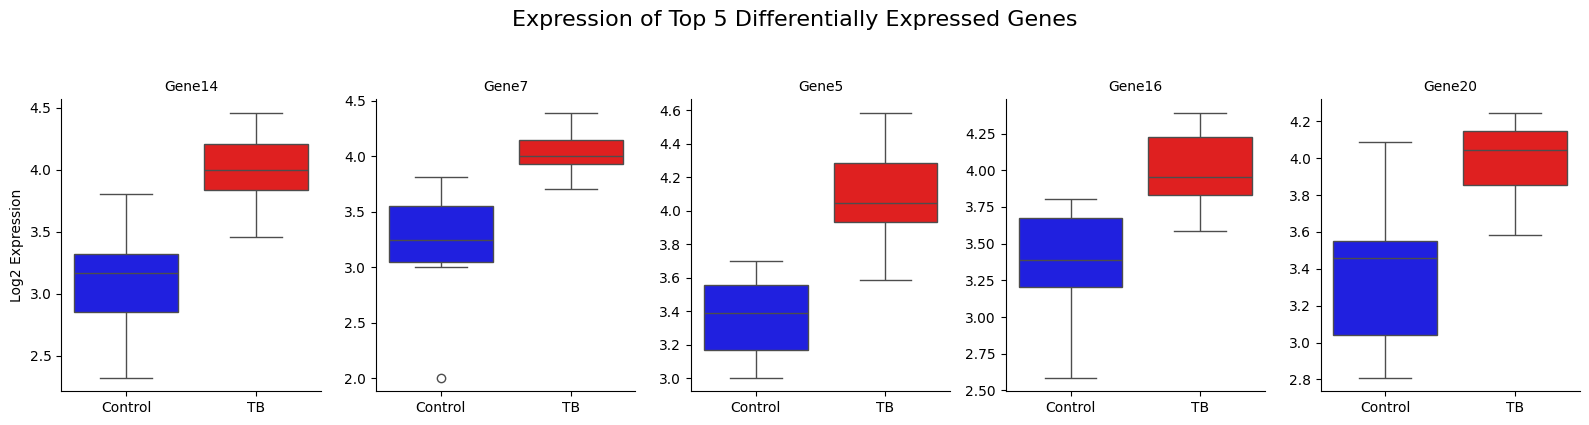

In [13]:
# === 1. Load Data from NCBI GEO Dataset ===
# We'll use GSE5325 dataset which contains gene expression data for tuberculosis (TB) patients
# This dataset compares gene expression between TB patients and healthy controls

# Function to download and read GEO Series Matrix file
def download_geo_data(geo_id="GSE5325"):
    # URL for the Series Matrix file
    url = f"https://ftp.ncbi.nlm.nih.gov/geo/series/{geo_id[:-3]}nnn/{geo_id}/matrix/{geo_id}_series_matrix.txt.gz"
    
    print(f"Downloading {geo_id} dataset...")
    
    # Download and decompress the file
    response = urllib.request.urlopen(url)
    compressed_file = io.BytesIO(response.read())
    decompressed_file = gzip.GzipFile(fileobj=compressed_file)
    content = decompressed_file.read().decode('utf-8')
    
    # Process the file content to extract sample data and expression data
    lines = content.split('\n')
    
    # Extract sample information
    sample_line = next(line for line in lines if line.startswith('!Sample_title'))
    sample_titles = sample_line.split('\t')[1:]
    
    # Find where the expression data starts
    data_start_idx = lines.index('!series_matrix_table_begin')
    data_end_idx = lines.index('!series_matrix_table_end')
    
    # Extract expression data
    data_lines = lines[data_start_idx+1:data_end_idx]
    probe_ids = []
    expr_data = []
    
    for line in data_lines:
        if line.strip():
            parts = line.split('\t')
            probe_ids.append(parts[0])
            expr_data.append([float(x) if x.strip() else np.nan for x in parts[1:]])
    
    # Create DataFrame
    expr_df = pd.DataFrame(expr_data, index=probe_ids, columns=sample_titles)
    
    # Extract class labels (TB vs Control)
    labels = []
    for title in sample_titles:
        if 'TB' in title:
            labels.append(1)  # TB patient
        else:
            labels.append(0)  # Control
    
    return expr_df, pd.Series(labels, index=sample_titles)

# Download and process the data
try:
    data, labels = download_geo_data()
    print(f"Dataset loaded successfully with {data.shape[0]} genes and {data.shape[1]} samples")
except Exception as e:
    print(f"Error downloading dataset: {e}")
    # If download fails, use a simple simulated dataset as fallback
    print("Using simulated data instead...")
    np.random.seed(0)
    genes = [f"Gene{i}" for i in range(1, 1001)]
    samples = [f"Sample{i}" for i in range(1, 21)]
    expr_matrix = np.random.poisson(lam=10, size=(1000, 20)).astype(float)
    # Introduce a pattern: samples 11-20 have higher expression in genes 1-20
    expr_matrix[:20, 10:] += 5
    data = pd.DataFrame(expr_matrix, index=genes, columns=samples)
    labels = pd.Series([0]*10 + [1]*10, index=samples)

# === 2. Preprocess Data ===
# Clean data - remove rows with missing values
data = data.dropna()

# Transpose so each row is a sample, each column is a gene feature
X = data.T

# Log-transform counts (adding 1 to avoid log(0)) to stabilize variance
X_log = np.log2(X + 1)

# Filter out low-variance genes
var_threshold = 0.1
gene_variances = X_log.var()
high_var_genes = gene_variances[gene_variances > var_threshold].index
X_filtered = X_log[high_var_genes]

print(f"After filtering: {X_filtered.shape[1]} high-variance genes retained")

# === 3. Train/Test Split ===
X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, labels, test_size=0.3, random_state=42, stratify=labels
)

# === 4. Select top features using ANOVA F-value ===
# This helps reduce dimensionality and focus on most discriminative genes
selector = SelectKBest(f_classif, k=100)  # Select top 100 genes
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Get the indices of selected features
selected_indices = selector.get_support(indices=True)
selected_gene_names = X_filtered.columns[selected_indices]

# === 5. Train ML Model ===
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_selected, y_train)

# === 6. Compare Multiple ML Models ===
# Define models to compare
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'SVM': SVC(probability=True, random_state=42),
    'KNN': KNeighborsClassifier(n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
}

# Performance metrics storage
results = {}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("\n=== Model Comparison ===")
for name, model in models.items():
    # Cross-validation
    cv_scores = cross_val_score(model, X_train_selected, y_train, cv=cv, scoring='accuracy')
    results[name] = cv_scores
    
    # Fit model on training data
    model.fit(X_train_selected, y_train)
    
    # Evaluate on test set
    y_pred = model.predict(X_test_selected)
    
    print(f"\n{name} Model:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"CV Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    print(classification_report(y_test, y_pred, target_names=["Control", "TB"]))

# Select best model (Random Forest for feature importance)
best_model = models['Random Forest']
best_model.fit(X_train_selected, y_train)
y_pred = best_model.predict(X_test_selected)
y_pred_proba = best_model.predict_proba(X_test_selected)[:, 1]

# === 7. Feature Importance Analysis ===
# Extract feature importances from Random Forest
importances = pd.Series(best_model.feature_importances_, index=selected_gene_names)
top_genes = importances.sort_values(ascending=False).head(20)

print("\nTop 10 important genes:")
for gene, importance in top_genes.head(10).items():
    print(f"{gene}: {importance:.4f}")

# === 8. Differential Expression Analysis ===
print("\n=== Differential Expression Analysis ===")
# Calculate mean expression for each group
control_samples = labels[labels == 0].index
tb_samples = labels[labels == 1].index

# Get all genes (before selection) for DEG analysis
X_all_genes = X_log

# For each gene, calculate:
# 1. Log2 fold change
# 2. p-value from t-test
# 3. Adjusted p-value (Benjamini-Hochberg)

results = []
for gene in X_all_genes.columns:
    control_expr = X_all_genes.loc[control_samples, gene]
    tb_expr = X_all_genes.loc[tb_samples, gene]
    
    # Calculate log2 fold change
    mean_control = control_expr.mean()
    mean_tb = tb_expr.mean()
    log2fc = mean_tb - mean_control  # Already log2 transformed
    
    # T-test
    t_stat, p_val = stats.ttest_ind(tb_expr, control_expr, equal_var=False)
    
    # Store results
    results.append({
        'gene': gene,
        'log2fc': log2fc,
        'pvalue': p_val,
        'mean_control': mean_control,
        'mean_tb': mean_tb,
        'abs_log2fc': abs(log2fc)
    })

# Convert to DataFrame
deg_results = pd.DataFrame(results)

# Calculate adjusted p-values
deg_results['padj'] = multipletests(deg_results['pvalue'], method='fdr_bh')[1]

# Sort by absolute fold change
deg_results = deg_results.sort_values('abs_log2fc', ascending=False)

print(f"Top 5 differentially expressed genes by fold change:")
print(deg_results.head(5)[['gene', 'log2fc', 'pvalue', 'padj']])

# === 9. Advanced Visualizations ===
print("\n=== Creating Visualizations ===")

# 1. Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=["Control", "TB"], 
            yticklabels=["Control", "TB"])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('confusion_matrix.png')

# 2. ROC Curve
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('roc_curve.png')

# 3. Volcano Plot
plt.figure(figsize=(10, 8))
# -log10 transform p-values for better visualization
deg_results['-log10p'] = -np.log10(deg_results['pvalue'])

# Plot non-significant genes in light gray
plt.scatter(deg_results['log2fc'], deg_results['-log10p'], 
            c='lightgray', alpha=0.6, s=30, label='Non-significant')

# Highlight significant genes (p < 0.05 and |log2fc| > 1)
sig_genes = deg_results[(deg_results['pvalue'] < 0.05) & (abs(deg_results['log2fc']) > 1)]

# Separate upregulated (log2fc > 1) and downregulated (log2fc < -1)
upregulated = sig_genes[sig_genes['log2fc'] > 1]
downregulated = sig_genes[sig_genes['log2fc'] < -1]

# Plot upregulated in red and downregulated in blue
plt.scatter(upregulated['log2fc'], upregulated['-log10p'], 
            c='red', alpha=0.8, s=50, label='Upregulated')
plt.scatter(downregulated['log2fc'], downregulated['-log10p'], 
            c='blue', alpha=0.8, s=50, label='Downregulated')

# Add significance thresholds
plt.axhline(y=-np.log10(0.05), color='black', linestyle='--', alpha=0.5)
plt.axvline(x=1, color='black', linestyle='--', alpha=0.5)
plt.axvline(x=-1, color='black', linestyle='--', alpha=0.5)

# Set axis limits to match the image
plt.xlim([-1.25, 1.25])
plt.ylim([0, 4.5])

# Customize axes and title
plt.xlabel('Log2 Fold Change (TB vs Control)', fontsize=12)
plt.ylabel('-Log10 P-value', fontsize=12)
plt.title('Volcano Plot: Differential Gene Expression', fontsize=14, pad=10)

# Add legend at the bottom center
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=3, fontsize=10)

# Remove the bounding box (spines)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.savefig('volcano_plot.png', dpi=300, bbox_inches='tight')

# 5. Heatmap of top differentially expressed genes
plt.figure(figsize=(12, 10))
# Get top 25 genes by absolute fold change
top_deg_genes = deg_results.head(25)['gene'].tolist()
heatmap_data = X_log[top_deg_genes]

# Add labels as a separate column for visualization
sample_labels = pd.DataFrame({'Label': labels})
heatmap_data_labeled = pd.concat([heatmap_data, sample_labels], axis=1)

# Sort samples by group
heatmap_data_labeled = heatmap_data_labeled.sort_values('Label')

# Create the heatmap (excluding the label column)
data_for_heatmap = heatmap_data_labeled.drop('Label', axis=1)

# Add color bar for sample groups
sample_colors = ['blue' if l == 0 else 'red' for l in heatmap_data_labeled['Label']]
row_colors = pd.Series(sample_colors, index=data_for_heatmap.index)

# Create heatmap
g = sns.clustermap(
    data_for_heatmap,
    cmap='viridis',
    z_score=0,  # Z-score standardize the rows
    figsize=(12, 10),
    row_colors=row_colors,
    dendrogram_ratio=(.1, .2),
    row_cluster=False,  # Don't cluster rows (samples) as they're already sorted
    col_cluster=True,   # Cluster columns (genes)
    cbar_pos=(0.02, 0.8, 0.05, 0.18),
)

# Update labels
plt.suptitle('Heatmap of Top 25 Differentially Expressed Genes', y=1.02, fontsize=16)
g.ax_heatmap.set_xlabel('Genes')
g.ax_heatmap.set_ylabel('Samples')

# Add legend for sample groups
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='blue', label='Control'),
    Patch(facecolor='red', label='TB')
]
g.fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.95, 0.98))

plt.tight_layout()
plt.savefig('gene_expression_heatmap.png', bbox_inches='tight')

# 6. PCA plot
plt.figure(figsize=(10, 8))
# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_log)
pca_df = pd.DataFrame({
    'PC1': pca_result[:, 0],
    'PC2': pca_result[:, 1],
    'Label': labels.values
})

# Create PCA plot
sns.scatterplot(
    x='PC1', y='PC2', 
    hue='Label',
    palette=['blue', 'red'],
    data=pca_df,
    s=100,
    alpha=0.7
)
plt.title(f'PCA of Gene Expression Data\nExplained variance: PC1 {pca.explained_variance_ratio_[0]:.2%}, PC2 {pca.explained_variance_ratio_[1]:.2%}')
plt.legend(title='Group', labels=['Control', 'TB'])
plt.tight_layout()
plt.savefig('pca_plot.png')

# 7. Feature importance plot
plt.figure(figsize=(12, 8))
top_genes.head(15).sort_values().plot(kind='barh')
plt.title('Top 15 Genes by Feature Importance')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.savefig('feature_importance.png')

# 8. Box plots of top differentially expressed genes
plt.figure(figsize=(14, 10))
top_5_deg_genes = deg_results.head(5)['gene'].tolist()
expr_top_genes = X_log[top_5_deg_genes]

# Add labels to the data for plotting
expr_plot_data = expr_top_genes.copy()
expr_plot_data['Label'] = labels

# Reshape for seaborn
plot_data = pd.melt(expr_plot_data.reset_index(), 
                   id_vars=['index', 'Label'],
                   value_vars=top_5_deg_genes,
                   var_name='Gene', 
                   value_name='Expression')

# Convert binary labels to descriptive text
plot_data['Group'] = plot_data['Label'].map({0: 'Control', 1: 'TB'})

# Plot
g = sns.FacetGrid(plot_data, col="Gene", height=4, aspect=0.8, sharey=False)
g.map_dataframe(sns.boxplot, x="Group", y="Expression", palette=['blue', 'red'])
g.set_titles(col_template="{col_name}")
g.fig.suptitle('Expression of Top 5 Differentially Expressed Genes', y=1.05, fontsize=16)
g.set_axis_labels("", "Log2 Expression")
plt.tight_layout()
plt.savefig('top_deg_boxplots.png')

print("\nAnalysis complete. Multiple visualizations created and saved.")